<center><h1>Xie_Qinghui_HW7</h1></center>

Name: Qinghui Xie
<br>
Github Username: qxie44
<br>
USC ID: 7956658480

## 1. Multi-class and Multi-Label Classification Using Support Vector Machines

Import packages

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler , LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import hamming_loss, accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from imblearn.over_sampling import SMOTE


### (a) Download the Anuran Calls (MFCCs) Data Set

In [ ]:
anuran_df = pd.read_csv("../data/Frogs_MFCCs.csv")
#70% of data to train
anuran_df = anuran_df.drop(columns = ['RecordID'])
train_data, test_data = train_test_split(anuran_df, test_size=0.3, random_state=44)
anuran_df.head()


,MFCCs_ 1,MFCCs_ 2,MFCCs_ 3,MFCCs_ 4,MFCCs_ 5,MFCCs_ 6,MFCCs_ 7,MFCCs_ 8,MFCCs_ 9,MFCCs_10,...,MFCCs_17,MFCCs_18,MFCCs_19,MFCCs_20,MFCCs_21,MFCCs_22,Family,Genus,Species,RecordID
0,1.0,0.152936,-0.105586,0.200722,0.317201,0.260764,0.100945,-0.150063,-0.171128,0.124676,...,-0.108351,-0.077623,-0.009568,0.057684,0.118680,0.014038,Leptodactylidae,Adenomera,AdenomeraAndre,1
1,1.0,0.171534,-0.098975,0.268425,0.338672,0.268353,0.060835,-0.222475,-0.207693,0.170883,...,-0.090974,-0.056510,-0.035303,0.020140,0.082263,0.029056,Leptodactylidae,Adenomera,AdenomeraAndre,1
2,1.0,0.152317,-0.082973,0.287128,0.276014,0.189867,0.008714,-0.242234,-0.219153,0.232538,...,-0.050691,-0.023590,-0.066722,-0.025083,0.099108,0.077162,Leptodactylidae,Adenomera,AdenomeraAndre,1
3,1.0,0.224392,0.118985,0.329432,0.372088,0.361005,0.015501,-0.194347,-0.098181,0.270375,...,-0.136009,-0.177037,-0.130498,-0.054766,-0.018691,0.023954,Leptodactylidae,Adenomera,AdenomeraAndre,1
4,1.0,0.087817,-0.068345,0.306967,0.330923,0.249144,0.006884,-0.265423,-0.172700,0.266434,...,-0.048885,-0.053074,-0.088550,-0.031346,0.108610,0.079244,Leptodactylidae,Adenomera,AdenomeraAndre,1


### (b) Train a classifier for each label

In [ ]:

X_train = train_data.drop(columns=['Family', 'Genus', 'Species'])
y_train = train_data[['Family', 'Genus', 'Species']]
X_test = test_data.drop(columns=['Family', 'Genus', 'Species'])
y_test = test_data[['Family', 'Genus', 'Species']]

#for standarizing and scaling
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

#### (i) Research

Exact match is measuring how many instances have all the labels predicted correctly. 
Hamming score or hamming loss measures the fraction of incorrectly predicted labels. 

#### (ii) Train a SVM for each of the labels

In [22]:
#each label encoded
label_encoders = []
y_train_encoded = []
y_test_encoded = []
for i in range(y_train.shape[1]):
    #encode categorical to numerical 
    le = LabelEncoder()
    #fit to data and transform
    y_train_encoded.append(le.fit_transform(y_train.iloc[:, i]))
    y_test_encoded.append(le.transform(y_test.iloc[:, i]))
    label_encoders.append(le)

#convert to array and swap column/ row
y_train_encoded = np.array(y_train_encoded).T
y_test_encoded = np.array(y_test_encoded).T

#looking at class distribution in training
for i in range(y_train_encoded.shape[1]):
    label_dist = pd.Series(y_train_encoded[:, i]).value_counts()
    print(f"Class distribution for label {i}:")
    print(label_dist)
    print()

Class distribution for label 0:
3    3081
2    1515
1     386
0      54
Name: count, dtype: int64

Class distribution for label 1:
0    2891
3    1123
1     386
2     213
4     190
7     107
5      72
6      54
Name: count, dtype: int64

Class distribution for label 2:
1    2411
5     792
0     480
2     386
4     331
3     213
6     190
9     107
7      72
8      54
Name: count, dtype: int64



In [ ]:

#store predictions and set crossval and gamma
Cval_range = [0.1, 1, 10]
gamma_range = [0.01, 0.1, 1]
predictions = []

#separate model for each label
for i in range(y_train_encoded.shape[1]):
    param_grid = {'C': Cval_range, 'gamma': gamma_range}
    #gaussin kernal 
    svm = SVC(kernel='rbf')
    #10 fold cross val
    grid_search = GridSearchCV(svm, param_grid, cv=10, scoring='accuracy')
    grid_search.fit(X_train_scale, y_train_encoded[:, i])
    
    # Predict on test set for each label
    y_pred = grid_search.predict(X_test_scale)
    predictions.append(y_pred)
#transpose
predictionsT = np.array(predictions).T

# Evaluate the multi-label classifier
exact_match = np.mean(np.all(y_test_encoded == predictionsT, axis=1))
hamming = np.sum(y_test_encoded != predictionsT) / (y_test_encoded.shape[0] * y_test_encoded.shape[1])

print("Exact Match Score:", exact_match)
print("Hamming Loss:", hamming)

Exact Match Score: 0.9925891616489115
Hamming Loss: 0.0041685965724872626


#### (iii) Repeat 1(b)ii with L1-penalized SVMs

In [15]:
import warnings
warnings.filterwarnings('ignore')

predictionsL1 = []

for i in range(y_train_encoded.shape[1]):
    param_grid = {'C': Cval_range}
    svm = LinearSVC(penalty='l1', dual=False)
    grid_search = GridSearchCV(svm, param_grid, cv=10, scoring='accuracy')
    grid_search.fit(X_train_scale, y_train_encoded[:, i])
    
    # Predict on test set for each label
    y_pred = grid_search.predict(X_test_scale)
    predictionsL1.append(y_pred)

predictionsL1T = np.array(predictionsL1).T

# eval exact match and hamming loss
exact_matchl1 = np.mean(np.all(y_test_encoded == predictionsL1T, axis=1))
hammingL1 = np.sum(y_test_encoded != predictionsL1T) / (y_test_encoded.shape[0] * y_test_encoded.shape[1])

print("Exact Match Score:", exact_matchl1)
print("Hamming Loss:", hammingL1)

Exact Match Score: 0.9583140342751274
Hamming Loss: 0.01929905820595955


#### (iv) Repeat 1(b)iii by using SMOTE or any other method for imbalance

In [20]:
predictionsSMOTE = []

for i in range(y_train_encoded.shape[1]):
    # Apply SMOTE 
    smote = SMOTE()
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scale, y_train_encoded[:, i])
    
    # Set up SVM with RBF kernel
    param_grid = {'C': Cval_range, 'gamma': gamma_range}
    svm = SVC(kernel='rbf')
    grid_search = GridSearchCV(svm, param_grid, cv=10, scoring='accuracy')
    grid_search.fit(X_train_balanced, y_train_balanced)
    
    # predict on test
    y_pred = grid_search.predict(X_test_scale)
    predictionsSMOTE.append(y_pred)



In [21]:
predictionsSMOTET = np.array(predictionsSMOTE).T
#double check
print(predictionsSMOTET.shape)

exact_matchSMOTE = np.mean(np.all(y_test_encoded == predictionsSMOTET, axis=1))
hammingSMOTE = np.sum(y_test_encoded != predictionsSMOTET) / (y_test_encoded.shape[0] * y_test_encoded.shape[1])
print("Exact Match Score:", exact_matchSMOTE)
print("Hamming Loss:", hammingSMOTE)


(2159, 3)
Exact Match Score: 0.9921259842519685
Hamming Loss: 0.004014204106839586


Using the different classifiers, a SVM for each label performed slightly better than one using L1 penalization according to exact match score. SMOTE is slightly better than then all most likely due to the balancing of the classes. 

## 2. K-Means Clustering on a Multi-Class and Multi-Label Data Set

### (a) Use k-means clustering

In [ ]:
anuran_df = anuran_df.drop(columns = ['RecordID'])
anuran_df.head()

,MFCCs_ 1,MFCCs_ 2,MFCCs_ 3,MFCCs_ 4,MFCCs_ 5,MFCCs_ 6,MFCCs_ 7,MFCCs_ 8,MFCCs_ 9,MFCCs_10,...,MFCCs_16,MFCCs_17,MFCCs_18,MFCCs_19,MFCCs_20,MFCCs_21,MFCCs_22,Family,Genus,Species
0,1.0,0.152936,-0.105586,0.200722,0.317201,0.260764,0.100945,-0.150063,-0.171128,0.124676,...,-0.024017,-0.108351,-0.077623,-0.009568,0.057684,0.118680,0.014038,Leptodactylidae,Adenomera,AdenomeraAndre
1,1.0,0.171534,-0.098975,0.268425,0.338672,0.268353,0.060835,-0.222475,-0.207693,0.170883,...,0.012022,-0.090974,-0.056510,-0.035303,0.020140,0.082263,0.029056,Leptodactylidae,Adenomera,AdenomeraAndre
2,1.0,0.152317,-0.082973,0.287128,0.276014,0.189867,0.008714,-0.242234,-0.219153,0.232538,...,0.083536,-0.050691,-0.023590,-0.066722,-0.025083,0.099108,0.077162,Leptodactylidae,Adenomera,AdenomeraAndre
3,1.0,0.224392,0.118985,0.329432,0.372088,0.361005,0.015501,-0.194347,-0.098181,0.270375,...,-0.050224,-0.136009,-0.177037,-0.130498,-0.054766,-0.018691,0.023954,Leptodactylidae,Adenomera,AdenomeraAndre
4,1.0,0.087817,-0.068345,0.306967,0.330923,0.249144,0.006884,-0.265423,-0.172700,0.266434,...,0.062837,-0.048885,-0.053074,-0.088550,-0.031346,0.108610,0.079244,Leptodactylidae,Adenomera,AdenomeraAndre


In [54]:

X = anuran_df.drop(columns=['Family', 'Genus', 'Species'])
y = anuran_df[['Family', 'Genus', 'Species']]
#X_scaled = scaler.fit_transform(X)

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score



In [55]:
sil_scores = []
k_values = range(2, 51)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=44)
    kmeans.fit(X)
    sil_scores.append(silhouette_score(X, kmeans.labels_))

best_k = list(k_values)[sil_scores.index(max(sil_scores))]
print(best_k)




4


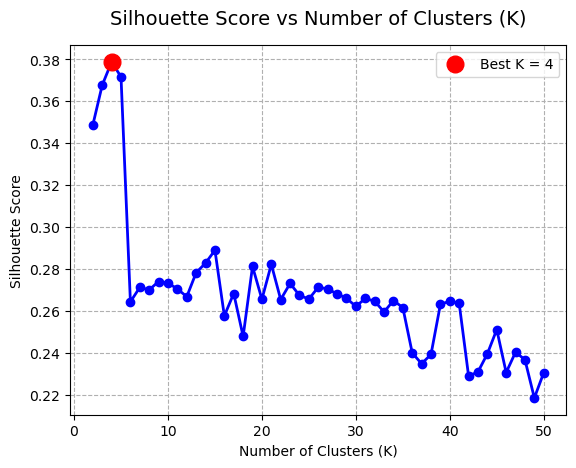

In [56]:
import matplotlib.pyplot as plt
#visualize the k
plt.plot(range(2, 51), sil_scores, 'bo-', linewidth=2, markersize=6)
plt.plot(best_k, sil_scores[best_k-2], 'ro', markersize=12, label=f'Best K = {best_k}')
plt.title('Silhouette Score vs Number of Clusters (K)', fontsize=14, pad=15)
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.grid(True, linestyle='--')
plt.legend()

In [ ]:

family_encoder = LabelEncoder()
genus_encoder = LabelEncoder()
species_encoder = LabelEncoder()
family_encoder.fit(y['Family'])
genus_encoder.fit(y['Genus'])
species_encoder.fit(y['Species'])

hamming_distances = []
hamming_losses = []  
hamming_scores = []

#chatgpt: how to loop 50 times without using the variable: said to use _
for _ in range(50):
    kmeans = KMeans(n_clusters=best_k, random_state=44)
    kmeans.fit(X)
    majority_labels = []

    for cluster in range(best_k):
        cluster_indices = np.where(kmeans.labels_ == cluster)[0]
        cluster_labels = y.iloc[cluster_indices]
        
        majority_family = cluster_labels['Family'].mode()[0]
        majority_genus = cluster_labels['Genus'].mode()[0]
        majority_species = cluster_labels['Species'].mode()[0]
        
        majority_labels.append((majority_family, majority_genus, majority_species))
    
    # Assign predicted labels
    predicted_labels = [majority_labels[cluster] for cluster in kmeans.labels_]
    predicted_labels = np.array(predicted_labels)
    
    #chatgpt: multiclass issues, how to mitigate so that it is one to one
    # Convert to arrays
    true_families = y['Family'].values
    true_genera = y['Genus'].values
    true_species = y['Species'].values
    
    pred_families = predicted_labels[:, 0]
    pred_genera = predicted_labels[:, 1]
    pred_species = predicted_labels[:, 2]
    
    # Calculate Hamming losses for each label type
    hamming_family = hamming_loss(
        family_encoder.transform(true_families),
        family_encoder.transform(pred_families)
    )
    
    hamming_genus = hamming_loss(
        genus_encoder.transform(true_genera),
        genus_encoder.transform(pred_genera)
    )
    
    hamming_species = hamming_loss(
        species_encoder.transform(true_species),
        species_encoder.transform(pred_species)
    )
    
    # Calculate average Hamming loss
    #hamming loss = incorrect predictions/ total predications
    average_hamming_loss = (hamming_family + hamming_genus + hamming_species) / 3
    hamming_losses.append(average_hamming_loss)
    
    # Hamming distance - total number of label mismatch

    total_differences = (
        np.sum(true_families != pred_families) +
        np.sum(true_genera != pred_genera) +
        np.sum(true_species != pred_species)
    )
    
    hamming_distances.append(total_differences)
    
    #  Hamming score is 1 - hamming loss
    hamming_score = 1 - average_hamming_loss
    hamming_scores.append(hamming_score)


### (b) Determine which family is the majority

In [71]:
print("Majority labels for each cluster:", majority_labels)

Majority labels for each cluster: [('Leptodactylidae', 'Adenomera', 'AdenomeraHylaedactylus'), ('Hylidae', 'Hypsiboas', 'HypsiboasCordobae'), ('Dendrobatidae', 'Ameerega', 'Ameeregatrivittata'), ('Hylidae', 'Hypsiboas', 'HypsiboasCinerascens')]


### (c) Calculate the average Hamming distance, Hamming score, and Hamming loss

In [73]:
total_samples = len(X) 
average_hamming_distance = np.mean(hamming_distances) / total_samples
std_hamming_distance = np.std(hamming_distances)

print("SD of Hamming Distance:", std_hamming_distance)
print(f"Average Hamming Loss: {np.mean(hamming_losses)}")
print(f"Average Hamming Score: {np.mean(hamming_scores)} ")
print(f"Average Hamming Distance: {np.mean(average_hamming_distance)} ")


SD of Hamming Distance: 0.0
Average Hamming Loss: 0.22242297892054666
Average Hamming Score: 0.7775770210794534 
Average Hamming Distance: 0.66726893676164 


## 3. ISLR 12.6.2

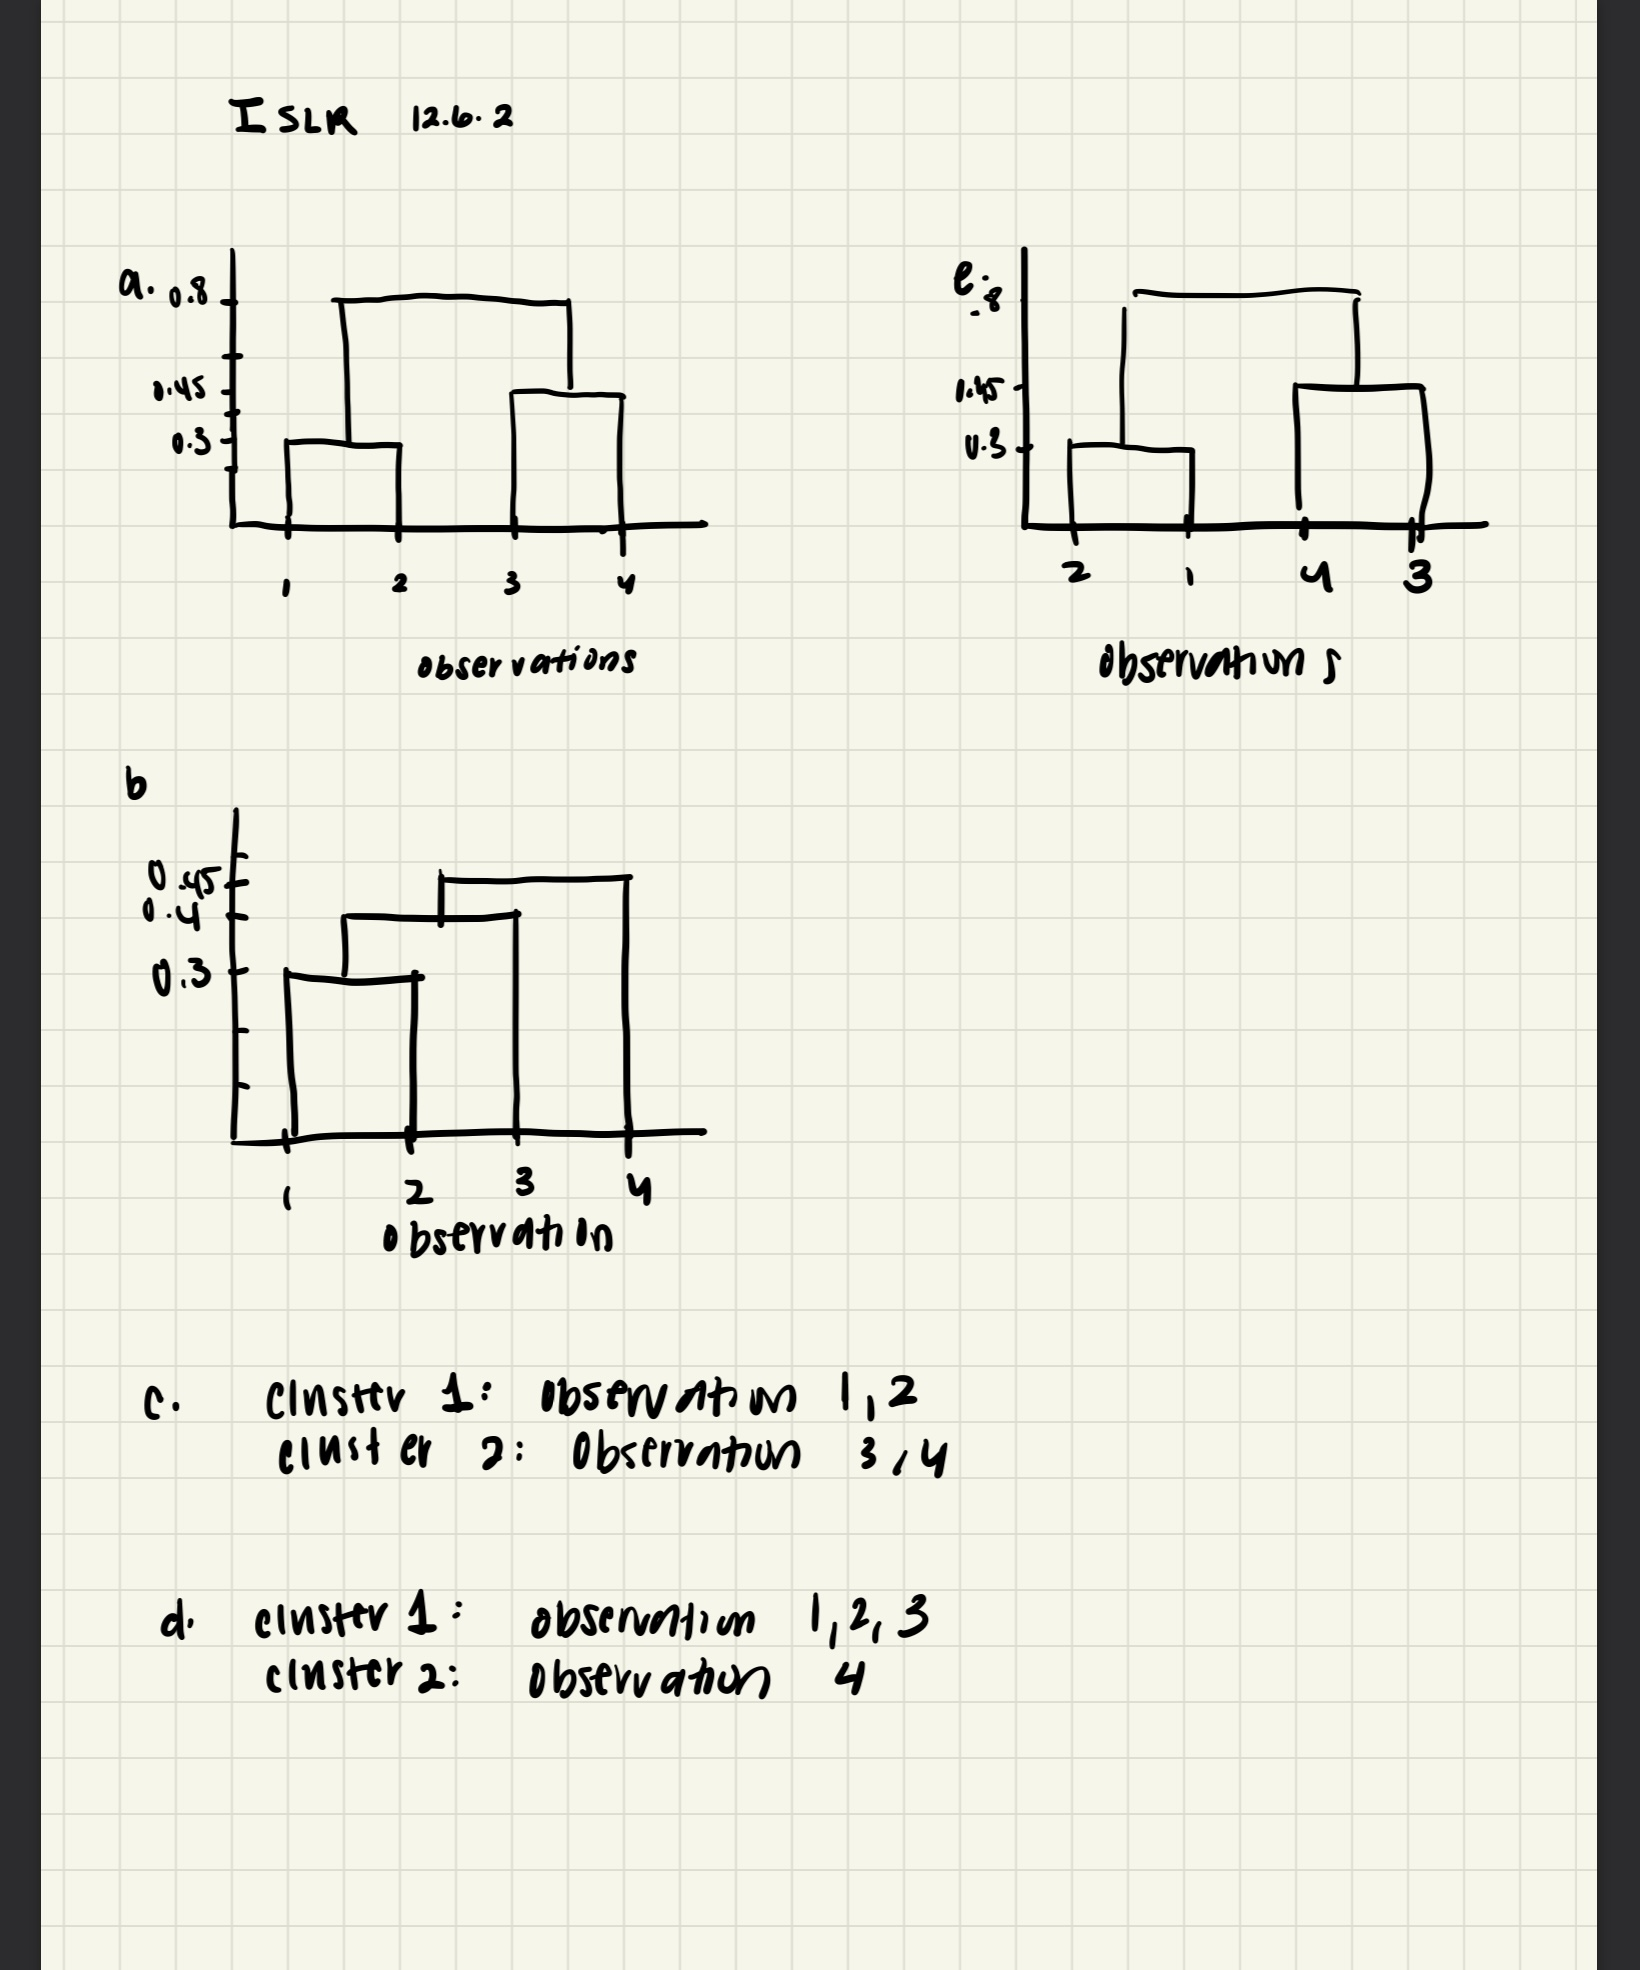

In [75]:
from IPython.display import Image
Image(filename='islr_12.6.2.jpg')